# Introduction

This notebook translates the behaviors, self-report measures, and paradigms of each domain in the [RDoC](https://www.nimh.nih.gov/research-priorities/rdoc/constructs/rdoc-matrix.shtml) framework into the language of the human neuroimaging literature. The objective is to maximize semantic similarity between the centroid of seed terms from RDoC and the centroid of a new list of terms for mental functions. Seed terms were scraped from RDoC version 5 on January 24, 2019. The work flow is as follows:

1. Compute the centroid of terms for mental functions for each domain in semantic space.
2. Identify the most semantically similar terms to each domain centroid across list lengths.
3. Select the word list length that maximizes semantic similarity to the domain centroid.

Our vector space model for semantic content is [GloVe](https://github.com/stanfordnlp/GloVe), which was trained on 29,828 human neuroimaging articles. The parameters for the GloVe model were a minimum word count of 5, window size of 15, and embedding dimension of 100 over 500 iterations.

# Load the data

In [1]:
import numpy as np
np.random.seed(42)

import pandas as pd
from collections import OrderedDict
import sys
sys.path.append("..")
import utilities, ontology

In [2]:
vsm_version = 190428 # Version of GloVe embeddings
dtm_version = 190325 # Version of document-term matrix
rdoc_version = 190124 # Version of RDoC matrix

## Vector space model

In [3]:
vsm = pd.read_csv("../data/text/glove_gen_n100_win15_min5_iter500_{}.txt".format(vsm_version), 
                    index_col=0, header=None, sep=" ")
print("Vocab N={}, Embedding N={}".format(vsm.shape[0], vsm.shape[1]))

Vocab N=350544, Embedding N=100


## Document-term matrix

In [4]:
dtm = utilities.load_doc_term_matrix(version=dtm_version, binarize=False)
dtm = dtm.loc[:, (dtm != 0).any(axis=0)]
print("Document N={}, Term N={}".format(dtm.shape[0], dtm.shape[1]))

Document N=18155, Term N=4107


## RDoC seed terms

In [5]:
seed_df = pd.read_csv("../lexicon/rdoc_{}/rdoc_seeds.csv".format(rdoc_version), 
                      index_col=None, header=0)
seed_df = seed_df.loc[seed_df["TOKEN"].isin(vsm.index)]
seed_df.head()

,ORDER,DOMAIN,CONSTRUCT,UNIT,TOKEN,CONFIDENCE
0,0,NEGATIVE_VALENCE,ACUTE_THREAT,CONSTRUCT,acute_threat,1
1,0,NEGATIVE_VALENCE,ACUTE_THREAT,CONSTRUCT,fear,1
2,0,NEGATIVE_VALENCE,ACUTE_THREAT,BEHAVIOR,analgesia,0
3,0,NEGATIVE_VALENCE,ACUTE_THREAT,BEHAVIOR,approach,0
4,0,NEGATIVE_VALENCE,ACUTE_THREAT,BEHAVIOR,avoidance,0


## Lexicon

In [6]:
lexicon = set([tkn.strip() for tkn in open("../lexicon/lexicon_cogneuro.txt", "r")])
lexicon = sorted(list(lexicon.union(seed_df["TOKEN"]).intersection(dtm.columns).intersection(vsm.index)))
len(lexicon)

1920

# Generate term lists

## 1. Load semantically similar terms

In [7]:
from style import style

In [8]:
list_len = 25
lists = ontology.load_rdoc_lists(lexicon, vsm, seed_df, dtm, verbose=True)
lists = lists.loc[lists["TOKEN"].isin(dtm.columns)]
lists.head()

,ORDER,DOMAIN,TOKEN,SOURCE,DISTANCE
0,0,NEGATIVE_VALENCE,avoidance,RDoC,0.247320
0,0,NEGATIVE_VALENCE,threat,RDoC,0.280856
0,0,NEGATIVE_VALENCE,anxiety,RDoC,0.285993
0,0,NEGATIVE_VALENCE,aggression,RDoC,0.346222
0,0,NEGATIVE_VALENCE,rumination,RDoC,0.370330


In [9]:
lists["ORDER"] = [style.order["rdoc"].index(dom) for dom in lists["DOMAIN"]]
lists = lists.sort_values(["ORDER", "DISTANCE"], ascending=[True, True])
lists.head(50)

,ORDER,DOMAIN,TOKEN,SOURCE,DISTANCE
0,0,NEGATIVE_VALENCE,avoidance,RDoC,0.247320
0,0,NEGATIVE_VALENCE,threat,RDoC,0.280856
0,0,NEGATIVE_VALENCE,anxiety,RDoC,0.285993
0,0,NEGATIVE_VALENCE,aggression,RDoC,0.346222
0,0,NEGATIVE_VALENCE,rumination,RDoC,0.370330
0,0,NEGATIVE_VALENCE,worry,RDoC,0.373153
0,0,NEGATIVE_VALENCE,reactivity,Lexicon,0.375755
0,0,NEGATIVE_VALENCE,anger,Lexicon,0.380146
0,0,NEGATIVE_VALENCE,emotional_reactivity,Lexicon,0.385858
0,0,NEGATIVE_VALENCE,frustration,RDoC,0.393254


In [10]:
lists.to_csv("lists/lists_rdoc.csv", index=None)

## 2. Optimize length by RDoC similarity

In [11]:
from scipy.spatial.distance import cosine

In [12]:
list_lens = range(5, 26)

In [13]:
doms = list(OrderedDict.fromkeys(lists["DOMAIN"]))

In [14]:
ops = []
df = pd.DataFrame(index=doms, columns=list_lens)
for dom in doms:
    seed_tkns = seed_df.loc[seed_df["DOMAIN"] == dom, "TOKEN"]
    seed_centroid = np.mean(vsm.loc[seed_tkns])
    for list_len in list_lens:
        len_tkns = lists.loc[lists["DOMAIN"] == dom, "TOKEN"][:list_len]
        len_centroid = np.mean(vsm.loc[len_tkns])
        df.loc[dom, list_len] = 1 - cosine(seed_centroid, len_centroid)
    sims = list(df.loc[dom])
    idx = sims.index(max(sims))
    ops.append(np.array(list_lens)[idx])
df["OPTIMAL"] = ops
df.to_csv("data/df_rdoc_opsim.csv")
df.head()

,5,6,7,8,9,10,11,12,13,14,...,17,18,19,20,21,22,23,24,25,OPTIMAL
NEGATIVE_VALENCE,0.858447,0.865093,0.864968,0.864137,0.865782,0.879029,0.879029,0.879029,0.879029,0.879029,...,0.879029,0.879029,0.879029,0.879029,0.879029,0.879029,0.879029,0.879029,0.879029,10
POSITIVE_VALENCE,0.898419,0.894114,0.889696,0.897615,0.905151,0.905229,0.911379,0.909201,0.90806,0.901763,...,0.914301,0.922164,0.922385,0.92505,0.928542,0.929278,0.936108,0.936533,0.936533,24
AROUSAL_REGULATION,0.836523,0.856207,0.862996,0.85398,0.855412,0.864617,0.86637,0.868041,0.876697,0.872356,...,0.891173,0.907722,0.911674,0.913034,0.917058,0.917632,0.917632,0.917632,0.917632,22
SOCIAL_PROCESSES,0.818991,0.826888,0.83563,0.842337,0.838425,0.849784,0.853777,0.851399,0.862,0.863071,...,0.857078,0.862755,0.873458,0.862501,0.870694,0.872998,0.87767,0.876539,0.878399,25
COGNITIVE_SYSTEMS,0.817073,0.815189,0.822245,0.813716,0.827354,0.829461,0.831466,0.832339,0.833024,0.840196,...,0.85738,0.854074,0.858991,0.859902,0.861271,0.860082,0.86495,0.864359,0.869823,25


In [15]:
columns = ["ORDER", "DOMAIN", "TOKEN", "SOURCE", "DISTANCE"]
new = pd.DataFrame(columns=columns)
for order, dom in enumerate(doms):
    list_len = df.loc[dom, "OPTIMAL"]
    dom_df = lists.loc[lists["DOMAIN"] == dom][:list_len]
    new = new.append(dom_df)
new = new.sort_values(["ORDER", "DISTANCE"], ascending=[True, True])
new.to_csv("lists/lists_rdoc_opsim.csv", index=None)
new.head(50)

,ORDER,DOMAIN,TOKEN,SOURCE,DISTANCE
0,0,NEGATIVE_VALENCE,avoidance,RDoC,0.247320
0,0,NEGATIVE_VALENCE,threat,RDoC,0.280856
0,0,NEGATIVE_VALENCE,anxiety,RDoC,0.285993
0,0,NEGATIVE_VALENCE,aggression,RDoC,0.346222
0,0,NEGATIVE_VALENCE,rumination,RDoC,0.370330
0,0,NEGATIVE_VALENCE,worry,RDoC,0.373153
0,0,NEGATIVE_VALENCE,reactivity,Lexicon,0.375755
0,0,NEGATIVE_VALENCE,anger,Lexicon,0.380146
0,0,NEGATIVE_VALENCE,emotional_reactivity,Lexicon,0.385858
0,0,NEGATIVE_VALENCE,frustration,RDoC,0.393254


# Assess similarity to seeds

## Load the comparison data

In [16]:
mccoy = pd.read_csv("lists/lists_cqh.csv", index_col=None)
mccoy["ORDER"] = [style.order["rdoc"].index(dom) for dom in mccoy["DOMAIN"]]
mccoy = mccoy.sort_values(["ORDER"], ascending=[True])
mccoy.head(200)

,DOMAIN,TOKEN,ORDER
0,NEGATIVE_VALENCE,aggression,0
65,NEGATIVE_VALENCE,respond,0
64,NEGATIVE_VALENCE,relaxed,0
63,NEGATIVE_VALENCE,refuse,0
62,NEGATIVE_VALENCE,posttraumatic_stress,0
61,NEGATIVE_VALENCE,posttraumatic,0
60,NEGATIVE_VALENCE,phobic,0
58,NEGATIVE_VALENCE,pessimistic,0
57,NEGATIVE_VALENCE,panic_disorder,0
66,NEGATIVE_VALENCE,sad,0


## Compute similarity to seeds

In [17]:
n_iter = 10000

### Centroids

In [18]:
seed_centroid = ontology.compute_centroid(seed_df, doms, vsm)
new_centroid = ontology.compute_centroid(new, doms, vsm)
mccoy_centroid = ontology.compute_centroid(mccoy, doms, vsm)

### Bootstrap distributions

In [19]:
new_sim_boot, mccoy_sim_boot = np.empty((len(doms), n_iter)), np.empty((len(doms)-1, n_iter))
for n in range(n_iter):
    
    new_sim_boot[:,n] = 1.0 - ontology.compute_sims_sample(new_centroid, seed_centroid, vsm)
    
    # Ignore last domain for McCoy, which was added to RDoC after its publication 
    mccoy_sim_boot[:(len(doms)-1),n] = (1.0 - ontology.compute_sims_sample(mccoy_centroid, seed_centroid, vsm))[:(len(doms)-1)]

### Null distributions

In [20]:
new_sim_null, mccoy_sim_null = np.empty((len(doms), n_iter)), np.empty((len(doms), n_iter))
for n in range(n_iter):
    
    new_sim_null[:,n] = 1.0 - ontology.compute_sims_shuffle(new_centroid, seed_centroid, vsm)
    
    # Ignore last domain for McCoy, which was added to RDoC after its publication 
    mccoy_sim_null[:len(doms)-1,n] = 1.0 - ontology.compute_sims_shuffle(mccoy_centroid, seed_centroid, vsm)[:len(doms)-1]

### Observed values

In [21]:
new_sim_obs = np.reshape(1.0 - ontology.compute_sims(new, seed_centroid, doms, vsm), (len(doms), 1))
mccoy_sim_obs = np.reshape(1.0 - ontology.compute_sims(mccoy, seed_centroid, doms, vsm), (len(doms), 1))

### Comparison tests

Is similarity to RDoC seed centroids higher for the **new vs. McCoy** method?

In [22]:
from statsmodels.stats.multitest import multipletests

In [23]:
alphas = [0.01, 0.001]

Is similarity to RDoC seed centroids higher for the **new vs. McCoy** method?

In [24]:
pvals_dif = np.sum(np.less(new_sim_boot[:(len(doms)-1),:] - mccoy_sim_boot, 0.0), axis=1) / n_iter
fdrs_dif = multipletests(pvals_dif, method="fdr_bh")[1] # Benjamini-Hochberg
ontology.report_significance(fdrs_dif, doms, alphas=alphas)

NEGATIVE_VALENCE       p=0.006900 *
POSITIVE_VALENCE       p=0.000000 **
AROUSAL_REGULATION     p=0.001625 *
SOCIAL_PROCESSES       p=0.000000 **
COGNITIVE_SYSTEMS      p=0.001625 *


Is similarity to RDoC seed centroids higher for the **new vs. null** method?

In [25]:
pvals_new = np.sum(np.less(new_sim_obs, new_sim_null), axis=1) / n_iter
fdrs_new = multipletests(pvals_new, method="fdr_bh")[1]
ontology.report_significance(fdrs_new, doms, alphas=alphas)

NEGATIVE_VALENCE       p=0.000000 **
POSITIVE_VALENCE       p=0.000000 **
AROUSAL_REGULATION     p=0.000000 **
SOCIAL_PROCESSES       p=0.000000 **
COGNITIVE_SYSTEMS      p=0.000000 **
SENSORIMOTOR_SYSTEMS   p=0.000000 **


Is similarity to RDoC seed centroids higher for the **McCoy vs. null** method?

In [26]:
pvals_mccoy = np.sum(np.less(mccoy_sim_obs[:-1], mccoy_sim_null[:-1,:]), axis=1) / n_iter
fdrs_mccoy = multipletests(pvals_mccoy, method="fdr_bh")[1]
ontology.report_significance(fdrs_mccoy, doms, alphas=alphas)

NEGATIVE_VALENCE       p=0.000000 **
POSITIVE_VALENCE       p=0.000000 **
AROUSAL_REGULATION     p=0.000000 **
SOCIAL_PROCESSES       p=0.000000 **
COGNITIVE_SYSTEMS      p=0.000000 **


### Null confidence interval

What is the 95% confidence interval for the **null** distribution of the **new** method?

In [27]:
interval = 0.95
lower = [sorted(new_sim_null[i,:])[int(n_iter*(1.0-interval))] for i in range(len(doms))]
upper = [sorted(new_sim_null[i,:])[int(n_iter*interval)] for i in range(len(doms))]

## Plot results

Comparison of new method vs. method of McCoy *et al.* in terms of similarity between the synonyms and RDoC seed terms. Statistics based on difference in means of bootstrap distributions for similarity.

In [28]:
import matplotlib.pyplot as plt
from matplotlib import cm, font_manager, rcParams
%matplotlib inline

In [29]:
font_lg = font_manager.FontProperties(fname=style.font, size=18)
font_xlg = font_manager.FontProperties(fname=style.font, size=24)
rcParams["axes.linewidth"] = 1.5

In [30]:
dom2name = {"NEGATIVE_VALENCE": "Negative Valence", 
             "POSITIVE_VALENCE": "Positive Valence", 
             "COGNITIVE_SYSTEMS": "Cognitive Systems", 
             "SOCIAL_PROCESSES": "Social Processes", 
             "AROUSAL_REGULATION": "Arousal & Regulation", 
             "SENSORIMOTOR_SYSTEMS": "Sensorimotor Systems"}
dom_names = [dom2name[dom] for dom in style.order["rdoc"]]
palette = style.palettes["rdoc"]

In [31]:
def plot_violin(boot, obs, labs, colors, fdrs=[], sig=False):
    for i, lab in enumerate(labs):
        data = sorted(boot[i,:])
        v = ax.violinplot(data, positions=[i], widths=0.8,
                          showmeans=False, showmedians=False)
        for pc in v["bodies"]:
            pc.set_facecolor(colors[i])
            pc.set_edgecolor(colors[i])
            pc.set_linewidth(2)
            pc.set_alpha(0.6)
        for line in ["cmaxes", "cmins", "cbars"]:
            v[line].set_edgecolor("none")
        plt.plot([i-0.355, i+0.36], [obs[i], obs[i]], 
                 c=colors[i], alpha=1, lw=2)
        if sig and i < len(fdrs):
            fdr = fdrs[i]
            for alpha, y in zip(alphas, [0, 0.06, 0.12]):
                if fdr < alpha:
                    plt.text(i-0.1325, max(data) + y, "*", 
                             fontproperties=font_xlg)

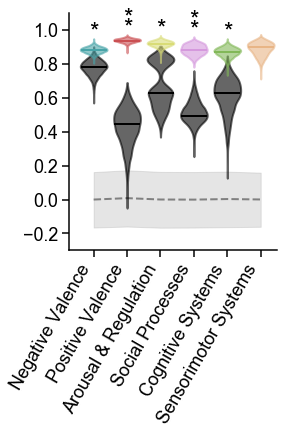

In [32]:
# Set up figure
fig = plt.figure(figsize=(2.9, 3.3))
ax = fig.add_axes([0,0,1,1])

# Null distributions as line plots
plt.fill_between(range(len(doms)), lower, y2=upper, 
                 color="gray", alpha=0.2, zorder=-100)
plt.plot(range(len(doms)), new_sim_null.mean(axis=1),
         "gray", linestyle="dashed", linewidth=2, zorder=-100)

# Bootstrap distributions as violin plots
plot_violin(mccoy_sim_boot, mccoy_sim_obs, doms[:-1], ["k"]*5)
plot_violin(new_sim_boot, new_sim_obs, doms, palette, 
            fdrs=fdrs_dif, sig=True)
        
# Set plot parameters
plt.xlim([-0.75, len(doms)-0.5])
plt.ylim([-0.3, 1.1])
for side in ["right", "top"]:
    ax.spines[side].set_visible(False)
ax.xaxis.set_tick_params(width=1.5, length=7)
ax.yaxis.set_tick_params(width=1.5, length=7)
ax.set_xticks(range(len(doms)))
ax.set_xticklabels(dom_names, rotation=60, 
                   ha="right", fontproperties=font_lg)
plt.yticks(fontproperties=font_lg)

# Export figure
plt.savefig("figures/rdoc_seed_sim.png", 
            dpi=250, bbox_inches="tight")
plt.show()

# Visualize the term lists

In [33]:
new["SIMILARITY"] = 1.0 - new["DISTANCE"]
new.head()

,ORDER,DOMAIN,TOKEN,SOURCE,DISTANCE,SIMILARITY
0,0,NEGATIVE_VALENCE,avoidance,RDoC,0.247320,0.752680
0,0,NEGATIVE_VALENCE,threat,RDoC,0.280856,0.719144
0,0,NEGATIVE_VALENCE,anxiety,RDoC,0.285993,0.714007
0,0,NEGATIVE_VALENCE,aggression,RDoC,0.346222,0.653778
0,0,NEGATIVE_VALENCE,rumination,RDoC,0.370330,0.629670


NEGATIVE_VALENCE


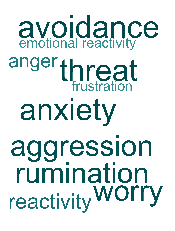

POSITIVE_VALENCE


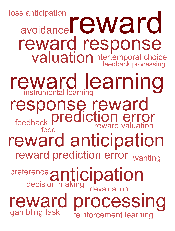

AROUSAL_REGULATION


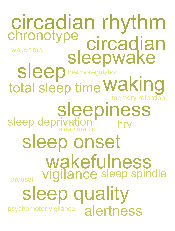

SOCIAL_PROCESSES


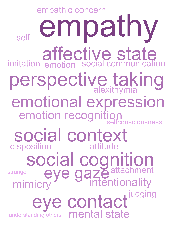

COGNITIVE_SYSTEMS


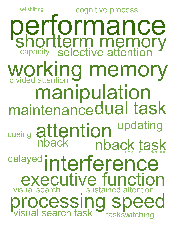

SENSORIMOTOR_SYSTEMS


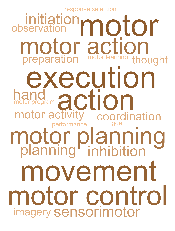

In [34]:
ontology.plot_wordclouds("rdoc", style.order["rdoc"], new, metric="SIMILARITY",
                         palette=palette, height=350, width=260, 
                         min_font_size=0, max_font_size=50,
                         brightness_offset=0.15, darkness_offset=-0.35, n_offsets=25)

# Visualize the circuits

In [35]:
from sklearn.preprocessing import binarize

## Compute PPMI-weighted links

In [36]:
act_bin = utilities.load_coordinates()
print("Document N={}, Structure N={}".format(act_bin.shape[0], act_bin.shape[1]))

Document N=18155, Structure N=118


In [37]:
dtm_bin = utilities.load_doc_term_matrix(version=dtm_version, binarize=True)

In [38]:
dom_scores = utilities.score_lists(new, dtm_bin, label_var="DOMAIN")

In [39]:
pmids = act_bin.index.intersection(dom_scores.index)
len(pmids)

18155

In [40]:
act_bin = act_bin.loc[pmids]
dom_scores = dom_scores.loc[pmids]

In [41]:
dom_links = ontology.compute_cooccurrences(act_bin, dom_scores)

In [42]:
n_iter = 10000
dom_links_null = ontology.compute_cooccurrences_null(act_bin, dom_scores, 
                                                     n_iter=n_iter, verbose=True)

Iteration 0
Iteration 1000
Iteration 2000
Iteration 3000
Iteration 4000
Iteration 5000
Iteration 6000
Iteration 7000
Iteration 8000
Iteration 9000


In [43]:
p = pd.DataFrame(index=act_bin.columns, columns=dom_scores.columns)
for i, struct in enumerate(act_bin.columns):
    for j, dom in enumerate(dom_scores.columns):
        obs = dom_links.values[i,j]
        null = dom_links_null[i,j,:]
        p.loc[struct, dom] = np.sum(null > obs) / float(n_iter)

In [44]:
fdr = multipletests(p.values.ravel(), method="fdr_bh")[1]
fdr = pd.DataFrame(fdr.reshape(p.shape), 
                   index=act_bin.columns, columns=dom_scores.columns)

In [45]:
dom_links_thres = dom_links[fdr < 0.01]
dom_links_thres = dom_links_thres.fillna(0.0)

In [46]:
dom_links_thres.to_csv("circuits/circuits_rdoc.csv")

## Map PPMI-weighted links

/anaconda3/envs/ontol/lib/python3.6/site-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


NEGATIVE_VALENCE     Min: 0.0000  Mean: 0.0476  Max: 0.3551


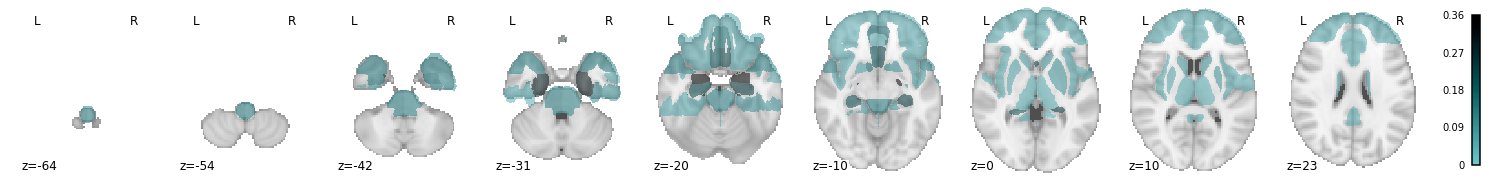

POSITIVE_VALENCE     Min: 0.0000  Mean: 0.0428  Max: 0.5940


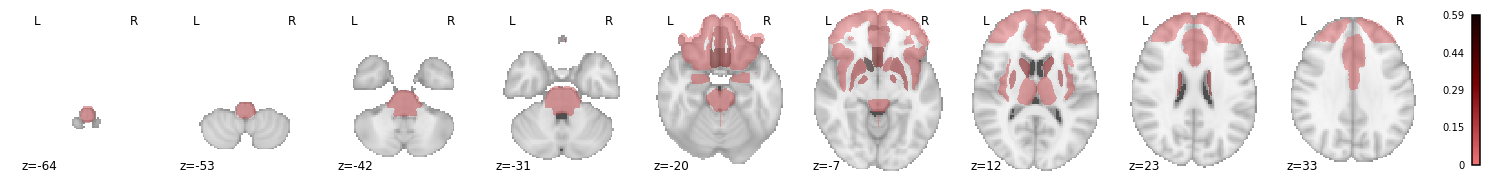

AROUSAL_REGULATION   Min: 0.0000  Mean: 0.0266  Max: 0.2251


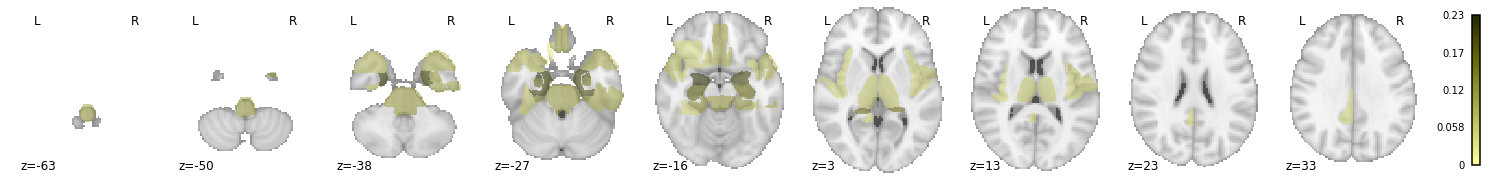

SOCIAL_PROCESSES     Min: 0.0000  Mean: 0.0446  Max: 0.2665


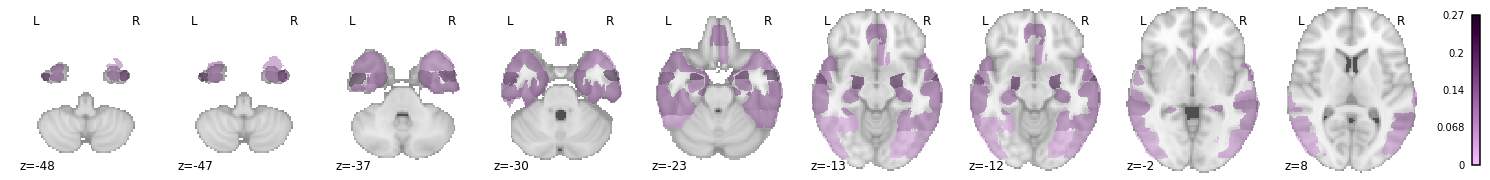

COGNITIVE_SYSTEMS    Min: 0.0000  Mean: 0.0250  Max: 0.1814


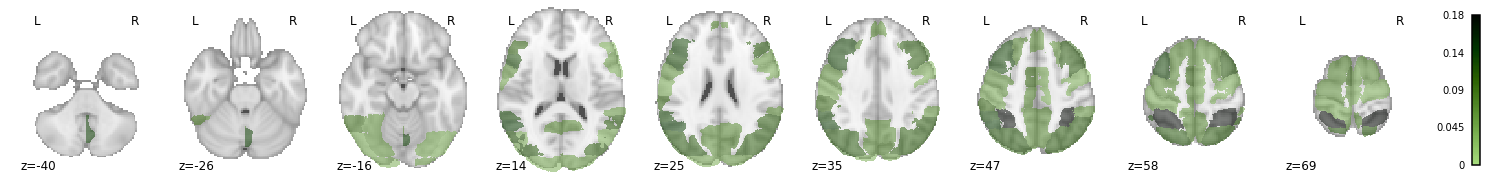

SENSORIMOTOR_SYSTEMS Min: 0.0000  Mean: 0.0343  Max: 0.2771


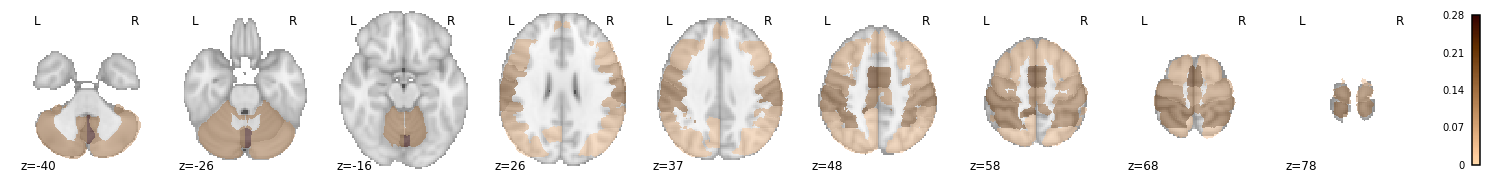

In [47]:
atlas = utilities.load_atlas()
path = "figures/circuits/rdoc"
cmaps = style.colormaps["rdoc"]
vmaxs = [round(v, 2) for v in dom_links_thres.max()]
for plane, verbose in zip(["z", "x", "y"], [True, False, False]):
    utilities.map_plane(dom_links_thres, atlas, path, suffix="_"+plane, cut_coords=9,
                        cmaps=cmaps, plane=plane, cbar=True, vmin=0.0, vmaxs=vmaxs,
                        verbose=verbose, print_fig=verbose)